## Imports

In [1]:
import xarray as xr
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import datetime
from pathlib import Path
import shutil

## Setup

In [4]:
nc_path = "/N/slate/jmelms/projects/FCN_dynamical_testing/data/output/ideal_default_60t.nc" # 
lat_path = "/N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/metadata/latitude.npy"
lon_path = "/N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/metadata/longitude.npy"
lsm_path = "/N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/metadata/land_sea_edges_mask.npy"
mean_path = "/N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/metadata/global_means.npy"
std_path = "/N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/metadata/global_stds.npy"
img_out_path = Path("/N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs")
img_out_path.mkdir(exist_ok=True)

## Loading Data

In [5]:
# load lat, lon, and land-sea mask
lat = np.load(lat_path)
lon = np.load(lon_path)
lsm = np.load(lsm_path)
mean = np.load(mean_path)
std = np.load(std_path)
nlat = lat.size
nlon = lon.size
dt = 6 # time step in hours

# load netcdf data
ds = xr.open_dataset(nc_path)

# get the data array
da = ds["__xarray_dataarray_variable__"]

# remove the "history" dimension because it's not used in these runs
da = da.squeeze(drop=True)

# check to make sure that the lat/lon dimensions are the same as the input data
assert da.lat.size == nlat, "Latitude dimensions do not match"
assert da.lon.size == nlon, "Longitude dimensions do not match"

# change time dimension to datetime.datetime if using real times
# ds["time"] = [datetime.datetime.fromtimestamp(t/10e8, tz=datetime.timezone.utc) for t in ds.time.values]

# change time dimension to hours from initialization if using relative times for idealized sim
da["time"] = [t/10e8/3600 for t in da.time.values]

# flatten mean and stds
mean = mean.squeeze()
std = std.squeeze()

print(da)

<xarray.DataArray '__xarray_dataarray_variable__' (time: 61, channel: 73,
                                                   lat: 721, lon: 1440)>
[4623282720 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 'u10m' 'v10m' 'u100m' ... 'r850' 'r925' 'r1000'
  * time     (time) float64 0.0 6.0 12.0 18.0 24.0 ... 342.0 348.0 354.0 360.0


### Util Functions

In [7]:
def dir2gif(img_dir, output_path, fps):
    img_paths = sorted(img_dir.glob("*.png"))
    images = [imageio.imread(img_path) for img_path in img_paths]
    imageio.mimsave(output_path, images, fps=fps)

def plotting_loop(dim_name, iterable, data, fig, obj, update_func, output_dir, fname_prefix, keep_images=False, fps=1):
    """
    Inputs:
        dim_name (str): name of the dimension to loop over
        iterable (normally time or variable)
        data (xarray dataset)
        fig (matplotlib figure)
        obj (prepared matplotlib image object on axis)
        update_func (function that updates the plot)
        output_dir (directory to save images)
        fname_prefix (prefix for image filenames)
        keep_images (if True, images will not be deleted after the loop)
        fps (frames per second for gif)

    Outputs
        a gif of the plot loop at the specified output_dir

    Return:
        fig
    """
    (output_dir/"imgs").mkdir(exist_ok=True, parents=True)
    for i, idx in enumerate(iterable):
        data_slice = data.sel({dim_name: idx}).values
        update_func(fig, obj, data_slice, i)
        fig.savefig(output_dir / "imgs" / f"{fname_prefix}_{i:03}.png")

    dir2gif(output_dir/"imgs", output_dir / f"{fname_prefix}.gif", fps=fps)

    if not keep_images:
        shutil.rmtree(output_dir/"imgs")

    return fig

## Example Usage of Utils

In [9]:
data = []
for i in range(100):
    field = np.random.default_rng().normal(0, 2*np.sin(i)+3, (100, 100))
    data.append(field)

data = xr.DataArray(np.array(data), dims=["time", "lat", "lon"])
fig, ax = plt.subplots()
im = ax.imshow(field, vmin=-10, vmax=10)
def example_plot_updater(fig, plot_obj, data, i): 
    plot_obj.set_data(data)
    fig.suptitle(f"Field at t={i}h")

plotting_loop("time", range(100), data, fig, im, example_plot_updater, img_out_path / "random", "ex", keep_images=True, fps=1)
plt.clf()

<Figure size 640x480 with 0 Axes>

## Plotting time series of tcwv

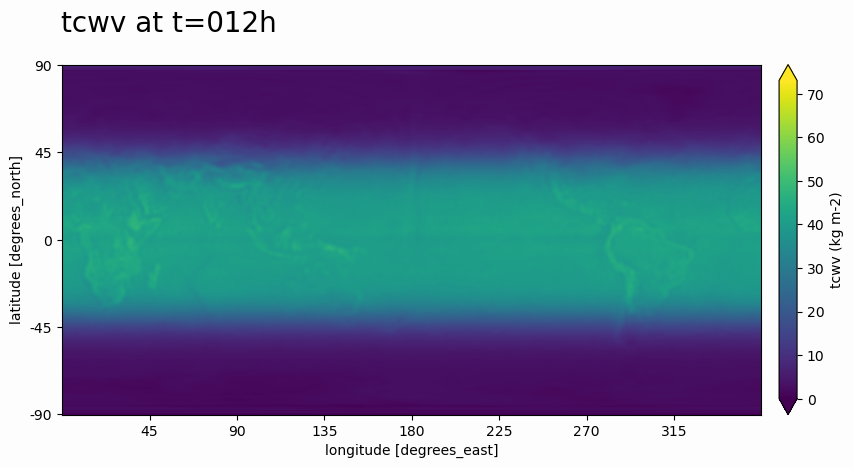

In [165]:
def context():
    # params
    data = da.sel(channel="tcwv")
    output_dir = img_out_path / "ideal_default_60t" / "tcwv"
    var = "tcwv"
    units = "kg m-2"
    title_f = lambda t: f"tcwv at t={t*6:03}h"
    cbar_label = f"{var} ({units})"
    iter_dim = "time"
    iterable_vals = da.time.values
    vmin, vmax = 0, data.values.max()
    cmap = cm.viridis # type: ignore
    figsize = (9, 5)
    xax_label = "longitude [degrees_east]"
    yax_label = "latitude [degrees_north]"
    xticks = np.linspace(0, nlon, 9, dtype=int)[1:-1]
    yticks = np.linspace(0, nlat-1, 5, dtype=int)
    xticklabs = lon[xticks].astype(int)
    yticklabs = lat[yticks].astype(int)
    adjust = {
        "top": 0.83,
        "bottom": 0.13,
        "left": 0.02, #"left": 0.025,
        "right": 0.93,
    }

    # plot setup
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(np.zeros((nlat, nlon)), vmin=vmin, vmax=vmax, cmap=cmap)
    fig.subplots_adjust(**adjust)
    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().y1-ax.get_position().y0]) # type: ignore
    cbar = fig.colorbar(im, cax=cax, extend="both")
    cbar.set_label(cbar_label)
    ax.set_xlabel(xax_label)
    ax.set_ylabel(yax_label)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    fig.patch.set_facecolor('xkcd:pale grey')

    # make plotting function
    def plot_updater(fig, plot_obj, data, i):
        plot_obj.set_data(data)
        fig.suptitle(title_f(i), fontsize=20, x=0.205, y=0.94)

    # run plotting loop
    plotting_loop(iter_dim, iterable_vals[:3], data, fig, im, plot_updater, output_dir, var, keep_images=True, fps=4)

context()

## Check a few timesteps of mslp

In [35]:
def context():
    vis_name = "mslp_time_series"
    output_dir = img_out_path / vis_name
    output_dir.mkdir(exist_ok=True, parents=True)

    channel = "mslp"
    units = "Pa"
    xticks = np.arange(0, nlon, 200)
    yticks = np.arange(0, nlat, 200)
    xticklabs = lon[xticks]
    yticklabs = lat[yticks]
    contour_levels = np.arange(900, 1100, 4) * 100

    # hPa = 100 Pa
    data = da.sel(channel="msl")

    vmin = data.min()
    vmax = data.max()

    # vmin = 800
    # vmax = 1200

    tstep = data.isel(time=1)
    
    # plot all timesteps
    for i, t in enumerate(da.time):
        if i % 10:
            continue
        t_str = str(t.values)
        tstep = data.sel(time=t)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 0.05]})
        ax1.imshow(tstep, cmap='viridis')
        CS = ax1.contour(tstep, levels=3, colors="black")
        ax1.clabel(CS, CS.levels, inline=True, fmt=lambda x: round(x), fontsize=10)
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.viridis
        scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        fig.colorbar(scalar_mappable, label=f"{channel} ({units})", cax=ax2, fraction=0.05, pad=0.07, )
        fig.suptitle(f'{channel} ({units}) at {t_str}h')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_xticks(xticks, xticklabs)
        ax1.set_yticks(yticks, yticklabs)

        fig.savefig(output_dir / f"{vis_name}_{i:04d}.png")
        print(f"Saved {output_dir / f'{vis_name}_{i:04d}.png'}")
        plt.close()

context()

Saved /N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs/mslp_time_series/mslp_time_series_0000.png
Saved /N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs/mslp_time_series/mslp_time_series_0010.png
Saved /N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs/mslp_time_series/mslp_time_series_0020.png
Saved /N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs/mslp_time_series/mslp_time_series_0030.png
Saved /N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs/mslp_time_series/mslp_time_series_0040.png
Saved /N/u/jmelms/BigRed200/projects/dynamical-tests-FCN/code/analysis/imgs/mslp_time_series/mslp_time_series_0050.png


### Checking all vars

In [6]:
def context():
    vis_name = "channels_t01_ideal_us"
    output_dir = img_out_path / vis_name
    output_dir.mkdir(exist_ok=True, parents=True)

    time = 0
    xticks = np.arange(0, nlon, 200)
    yticks = np.arange(0, nlat, 200)
    xticklabs = lon[xticks]
    yticklabs = lat[yticks]

    data = da.sel(time=slice(time, time+dt))
    
    # plot all timesteps
    for i, c in enumerate(da.channel):
        c_str = str(c.values)
        tsteps = data.isel(channel=i)
        vmin = tsteps.min().values
        vmax = tsteps.max().values
        
        # print(f"-/+ {c_str}: {vmin:.3f}/{vmax:.3f}")
        fig, axd = plt.subplot_mosaic("Ac\nBd", figsize=(10, 10), gridspec_kw={'width_ratios': [1, 0.05]})
        # fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 0.05]})
        t0ax = axd["A"]
        t1ax = axd["B"]
        cax = axd["c"]
        dax = axd["d"]
        for j, (ax, cbar_ax) in enumerate(((t0ax, cax), (t1ax, dax))):
            tstep = tsteps.isel(time=j)
            # vmin = tstep.min().values
            # vmax = tstep.max().values
            # vmean = tstep.mean().values
            # if j == 0:
            #     print(f"-/o/+ {c_str}: {vmin:.3f}/{vmean:.3f}/{vmax:.3f}")

            cmap = ax.imshow(tstep, cmap='viridis', vmin=vmin, vmax=vmax)
            # CS = ax.contour(tstep, levels=3, colors="black")
            # ax.clabel(CS, CS.levels, inline=True, fmt=lambda x: round(x), fontsize=10)
            fig.colorbar(cmap, label=f"{c_str}", cax=cbar_ax, fraction=0.05, pad=0.07)
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_xticks(xticks, xticklabs)
            ax.set_yticks(yticks, yticklabs)

        # cmap = ax1.imshow(tstep, cmap='viridis', vmin=vmin, vmax=vmax)
        # CS = ax1.contour(tstep, levels=3, colors="black")
        # ax1.clabel(CS, CS.levels, inline=True, fmt=lambda x: round(x), fontsize=10)
        # fig.colorbar(cmap, label=f"{c_str}", cax=ax2, fraction=0.05, pad=0.07, )
        fig.suptitle(f'{c_str} at {time}-{time+dt}h', fontsize=20)
        # ax1.set_xlabel('Longitude')
        # ax1.set_ylabel('Latitude')
        # ax1.set_xticks(xticks, xticklabs)
        # ax1.set_yticks(yticks, yticklabs)

        fig.savefig(output_dir / f"{vis_name}_{i:04d}.png")
        # print(f"Saved {output_dir / f'{vis_name}_{i:04d}.png'}")
        plt.close()

context()

In [36]:
da.sel(channel="msl").isel(time=slice(0,3)).min(dim=["lat", "lon"])

<xarray.DataArray '__xarray_dataarray_variable__' (time: 3)>
array([1.0133056e+05, 9.0678424e+07, 1.0381826e+08], dtype=float32)
Coordinates:
    channel  <U5 'msl'
  * time     (time) float64 0.0 6.0 12.0

In [9]:
for channel, m, v in zip(da.channel.values, mean, da.isel(time=0, lat=0, lon=0).values):
    print(f"{channel}, {m}, {v:.7f}")

# channels = da.channel.values
# mean.flatten()

u10m, -0.07404755800962448, -0.4377136
v10m, 0.19169427454471588, 0.5551453
u100m, -0.014596237801015377, -0.6719208
v100m, 0.1996840387582779, 1.0930634
t2m, 278.6412048339844, 242.4684448
sp, 96659.890625, 103071.3437500
msl, 100966.71875, 103071.8125000
tcwv, 18.4080867767334, 1.8022537
u50, 5.533691883087158, -0.0007172
u100, 10.243287086486816, -0.0005951
u150, 13.465484619140625, -0.0006561
u200, 14.088746070861816, 0.0009460
u250, 13.219594955444336, 0.0000916
u300, 11.678762435913086, 0.0006104
u400, 8.723402976989746, -0.0007935
u500, 6.4944610595703125, -0.0000763
u600, 4.757308483123779, -0.0002441
u700, 3.2801318168640137, -0.0000308
u850, 1.3569166660308838, -0.0002289
u925, 0.5785491466522217, -0.0001678
u1000, -0.05946159362792969, 0.0003967
v50, 0.003080817172303796, 0.0005493
v100, 0.0011228377697989345, 0.0000763
v150, -0.049639418721199036, -0.0004120
v200, -0.046308573335409164, 0.0001678
v250, -0.03826545551419258, 0.0007324
v300, -0.030652925372123718, -0.0005951


In [32]:
msls = ds.sel(channel="msl")["__xarray_dataarray_variable__"].isel(time=slice(0,3), lat=0, lon=0).values
mslus = msls * std[6] + mean[6]
mslus

array([[1.0133056e+05],
       [9.6606008e+07],
       [1.0779178e+08]], dtype=float32)

In [31]:
ex = 0.26925582
exus = ex * std[6] + mean[6]
exus

101325.00000354329

In [33]:
ncin = xr.open_dataset(nc_path)["__xarray_dataarray_variable__"]
ncin.sel(channel="msl").isel(time=0, lat=0, lon=0).values

array([0.2734375], dtype=float32)